Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


                                        Original   KNN Imputed  MICE Imputed  \
goal_paid_parachute_on_time         1.163748e-01  1.162414e-01  1.161938e-01   
user_id                             2.824611e+13  2.824611e+13  2.824611e+13   
count_apply_savings_to_cc           2.875254e+00  2.875254e+00  2.875254e+00   
count_auto_withdrawal               8.187311e-02  8.187311e-02  8.187311e-02   
count_chat_before_new_debt          1.078896e-01  1.078896e-01  1.078896e-01   
count_chat_for_debt_reduction       7.347666e-02  7.347666e-02  7.347666e-02   
count_contact_biller                2.243531e-01  2.243531e-01  2.243531e-01   
count_no_new_debt_upcoming_month    8.564367e-01  8.564367e-01  8.564367e-01   
count_pay_more_on_cc                5.098957e+00  5.098957e+00  5.098957e+00   
count_pay_of_cc                     1.462854e-01  1.462854e-01  1.462854e-01   
count_spend_less                    1.753747e-01  1.753747e-01  1.753747e-01   
count_custom1                       9.26

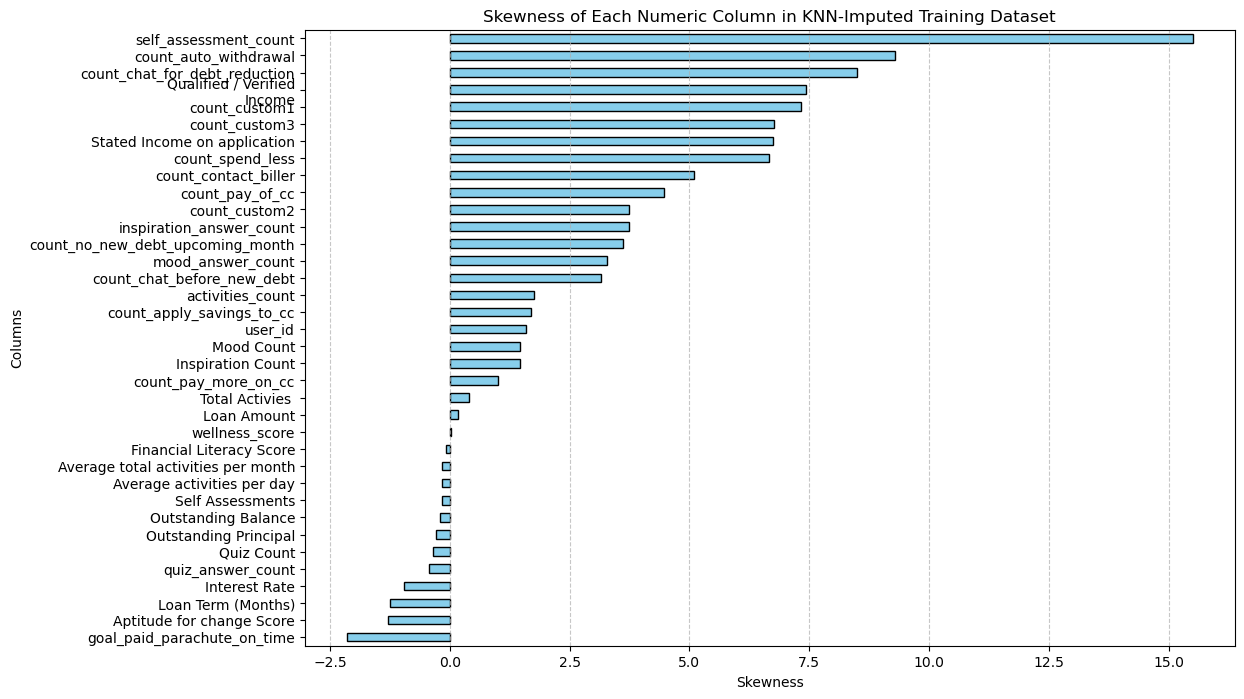

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy.stats import skew

# Load Data
dfcrosssection = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Parachute - Cross Section')
dfcrosssection['ID'] = dfcrosssection['ID'].astype(str)
dftupanel = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='TU - Panel')
dfmonthlywellness = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Monthly Wellness and Engagement')
dfmonthlywellness['loanid'] = dfmonthlywellness['loanid'].astype(str)
dfGoals_and_plans_ALLDATA_202410 = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Goals_and_plans_ALLDATA_202410')
dfGoals_and_plans_ALLDATA_202410['public_id'] = '1' + dfGoals_and_plans_ALLDATA_202410['public_id'].astype(str)
dfAddiitonalTUData = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Addiitonal TU Data')

# Merge Data
merged_data = dfGoals_and_plans_ALLDATA_202410.merge(dfmonthlywellness, how='left', left_on='public_id', right_on='loanid')
merged_data = merged_data.merge(dfcrosssection, how='left', left_on='public_id', right_on='ID')

# Drop Columns
merged_data = merged_data.drop(columns=['id', 'assessment_month', 'admin_notes', 'id-date', 'ID'])

# Drop Duplicates and Nulls
distinct_rows = merged_data.drop_duplicates().dropna(subset=['Loan Status'])

# Convert date columns to datetime
date_columns = ['assessment_completed_date', 'month_being_assessed', 'plan_date1', 'Disbursement Date', 'Date of Birth']
for col in date_columns:
    distinct_rows[col] = pd.to_datetime(distinct_rows[col], errors='coerce')

# Drop columns with more than 80% missing values
missing_values = distinct_rows.isnull().mean() * 100
columns_to_drop = missing_values[missing_values > 80].index
df_cleaned = distinct_rows.drop(columns=columns_to_drop)

# Step 1: Split Data
train_data, test_data = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Step 2: Imputation on Training Data Only
numeric_cols = train_data.select_dtypes(include=[np.number]).columns

# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
train_knn_imputed = train_data.copy()
train_knn_imputed[numeric_cols] = knn_imputer.fit_transform(train_knn_imputed[numeric_cols])

# Impute test set based on training fit
test_knn_imputed = test_data.copy()
test_knn_imputed[numeric_cols] = knn_imputer.transform(test_knn_imputed[numeric_cols])

# MICE Imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=0)
train_mice_imputed = train_data.copy()
train_mice_imputed[numeric_cols] = mice_imputer.fit_transform(train_mice_imputed[numeric_cols])

# Impute test set based on training fit
test_mice_imputed = test_data.copy()
test_mice_imputed[numeric_cols] = mice_imputer.transform(test_mice_imputed[numeric_cols])

# Conditional Median Imputation based on 'Province'
train_conditional_imputed = train_data.copy()
for col in numeric_cols:
    train_conditional_imputed[col] = train_conditional_imputed.groupby('Province')[col].transform(
        lambda x: x.fillna(x.median())
    )

test_conditional_imputed = test_data.copy()
for col in numeric_cols:
    test_conditional_imputed[col] = test_conditional_imputed.groupby('Province')[col].transform(
        lambda x: x.fillna(x.median())
    )

# Step 3: Variance Comparison Across Imputed Datasets for Training Data Only
comparison_df = pd.DataFrame({
    "Original": train_data[numeric_cols].var(),
    "KNN Imputed": train_knn_imputed[numeric_cols].var(),
    "MICE Imputed": train_mice_imputed[numeric_cols].var(),
    "Conditional Median Imputed": train_conditional_imputed[numeric_cols].var()
})

print(comparison_df)

# Step 4: Calculate and Plot Skewness for KNN-Imputed Training Data
knn_skewness = pd.Series(
    {col: skew(train_knn_imputed[col].dropna()) for col in numeric_cols},
    name="KNN Skewness"
)

print(knn_skewness)

# Plot skewness of each numeric column in KNN-imputed dataset
plt.figure(figsize=(12, 8))
knn_skewness.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Skewness of Each Numeric Column in KNN-Imputed Training Dataset')
plt.xlabel('Skewness')
plt.ylabel('Columns')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

First few rows of the merged dataset:


,id_x,public_id,assessment_completed_date,month_being_assessed,goal_no_new_debt,goal_paid_bills_on_time,goal_paid_parachute_on_time,reason,under_utilization,user_id,...,qualified / verified\nincome,aptitude for change score,financial literacy score,self assessments,quiz count,mood count,inspiration count,total activies,average total activities per month,average activities per day
0,6853,123,2022-08-03,2022-07-01,True,True,1.0,NaN,False,2241,...,116000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6853,123,2022-08-03,2022-07-01,True,True,1.0,NaN,False,2241,...,116000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6853,123,2022-08-03,2022-07-01,True,True,1.0,NaN,False,2241,...,116000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6853,123,2022-08-03,2022-07-01,True,True,1.0,NaN,False,2241,...,116000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6853,123,2022-08-03,2022-07-01,True,True,1.0,NaN,False,2241,...,116000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28134 entries, 0 to 28133
Data columns (total 66 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id_x                                28134 non-null  int64         
 1   public_id                           28134 non-null  object        
 2   assessment_completed_date           28134 non-null  datetime64[ns]
 3   month_being_assessed                28134 non-null  datetime64[ns]
 4   goal_no_new_debt                    28134 non-null  bool          
 5   goal_paid_bills_on_time             28134 non-null  bool          
 6   goal_paid_parachute_on_time         28094 non-null  float64       
 7   reason                              1892 non-null   object        
 8   under_utilization                   28134 non-null  bool          
 9   user_id                             28134 non-null  int64         
 10

,id_x,assessment_completed_date,month_being_assessed,goal_paid_parachute_on_time,user_id,plan_date1,plan_apply_savings_to_cc,plan_auto_withdrawal,plan_chat_before_new_debt,plan_chat_for_debt_reduction,...,qualified / verified\nincome,aptitude for change score,financial literacy score,self assessments,quiz count,mood count,inspiration count,total activies,average total activities per month,average activities per day
count,2.813400e+04,28134,28134,28094.000000,2.813400e+04,4527,4527.000000,4527.000000,4527.000000,4527.000000,...,27990.000000,27645.000000,27645.000000,24101.000000,24101.000000,24101.000000,24101.000000,24101.000000,24101.000000,24101.000000
mean,1.237419e+07,2023-12-30 13:17:54.088291840,2023-11-27 22:12:15.508637184,0.868015,3.325575e+06,2024-05-04 06:54:28.389661952,0.405567,0.011487,0.044179,0.015905,...,77307.798857,3.561664,2.220980,17.094436,133.384424,23.120908,13.439650,187.039417,10.035462,0.334516
min,6.056000e+03,2022-08-01 00:00:00,2022-07-01 00:00:00,0.000000,1.519000e+03,2024-02-01 00:00:00,0.000000,0.000000,0.000000,0.000000,...,32000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.061200,0.002000
25%,2.340905e+06,2023-09-01 00:00:00,2023-08-01 00:00:00,1.000000,6.785200e+04,2024-03-04 00:00:00,0.000000,0.000000,0.000000,0.000000,...,54000.000000,3.000000,0.000000,13.000000,101.000000,1.000000,0.000000,122.000000,8.775500,0.292500
50%,1.560273e+07,2024-02-01 00:00:00,2024-01-01 00:00:00,1.000000,7.817390e+05,2024-05-02 00:00:00,0.000000,0.000000,0.000000,0.000000,...,68000.000000,3.670000,3.000000,17.000000,136.000000,8.000000,4.000000,162.000000,9.430300,0.314300
75%,1.791654e+07,2024-06-03 00:00:00,2024-05-01 00:00:00,1.000000,2.072132e+06,2024-07-01 00:00:00,1.000000,0.000000,0.000000,0.000000,...,90000.000000,4.170000,4.000000,23.000000,178.000000,32.000000,17.000000,263.000000,11.134000,0.371100
max,2.085673e+07,2024-10-07 00:00:00,2024-09-01 00:00:00,1.000000,1.979250e+07,2024-08-09 00:00:00,1.000000,1.000000,1.000000,1.000000,...,605300.000000,5.000000,5.000000,26.000000,211.000000,120.000000,66.000000,404.000000,20.886100,0.696200
std,7.236577e+06,NaN,NaN,0.338481,5.332348e+06,NaN,0.491056,0.106570,0.205516,0.125120,...,59006.958893,1.030708,1.806144,5.922932,54.227447,31.145865,17.875628,95.802909,3.271540,0.109049



Summary Statistics for Categorical Variables:


,public_id,reason,description1,description2,description3,loanid,month,id_y,loan status,gender,province,residential status
count,28134,1892,78,211,93,28115,28115,27990,27990,27990,27990,27990
unique,192,111,7,15,8,183,28,187,4,2,9,4
top,1280,"I did pay my loan on time every month, how it ...",This month was a one off as I usually pay my b...,My employer owes me OT pay + retro pay. Those ...,lkjhgfd,1280,2024-03,1280,Active,MALE,ON,RENTER
freq,702,27,26,26,23,702,1581,702,23484,16368,20158,18815



Missing Values in the Dataset:


,Total Missing,Percent Missing
description1,28056,99.722755
description3,28041,99.669439
description2,27923,99.250018
reason,26242,93.275041
plan_apply_savings_to_cc,23607,83.909149
plan_auto_withdrawal,23607,83.909149
plan_pay_of_cc,23607,83.909149
plan_pay_more_on_cc,23607,83.909149
plan_no_new_debt_upcoming_month,23607,83.909149
plan_contact_biller,23607,83.909149


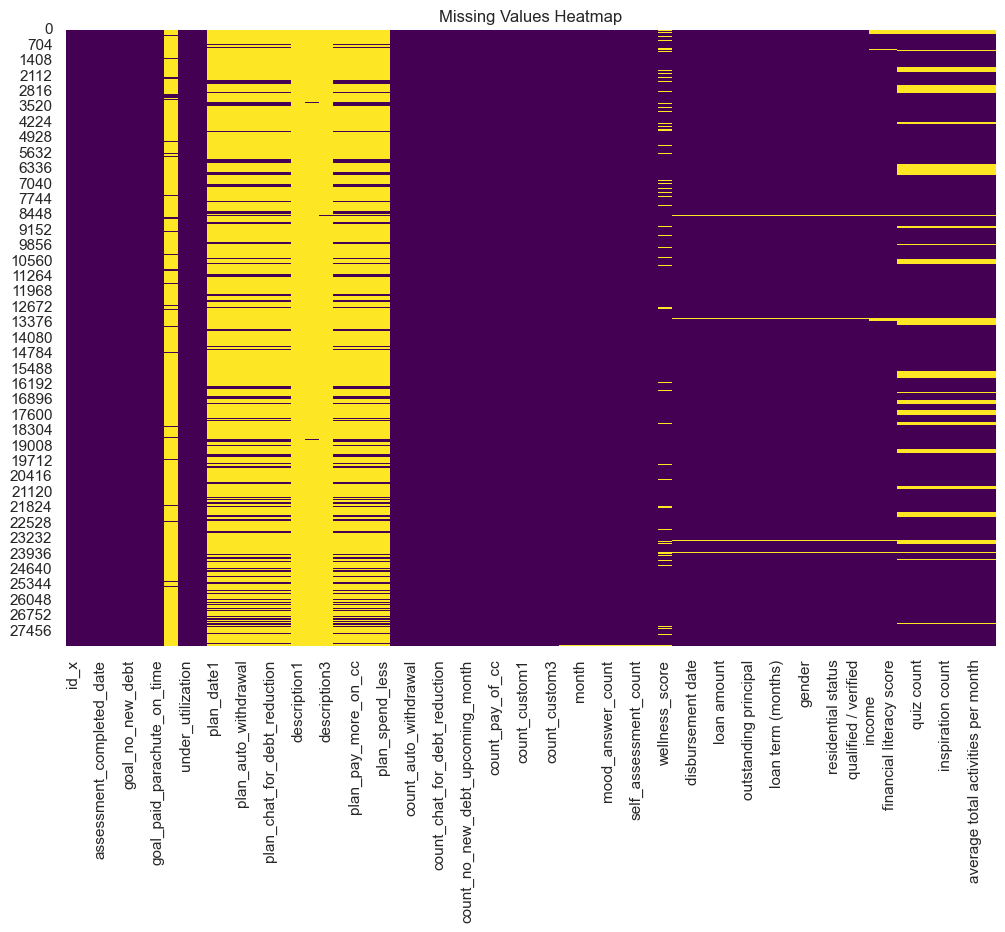


Dropped columns due to high missing rate (> 50%):
['description1', 'description3', 'description2', 'reason', 'plan_apply_savings_to_cc', 'plan_auto_withdrawal', 'plan_pay_of_cc', 'plan_pay_more_on_cc', 'plan_no_new_debt_upcoming_month', 'plan_contact_biller', 'plan_chat_for_debt_reduction', 'plan_chat_before_new_debt', 'plan_spend_less', 'plan_date1']

Plotting histograms for numeric variables...


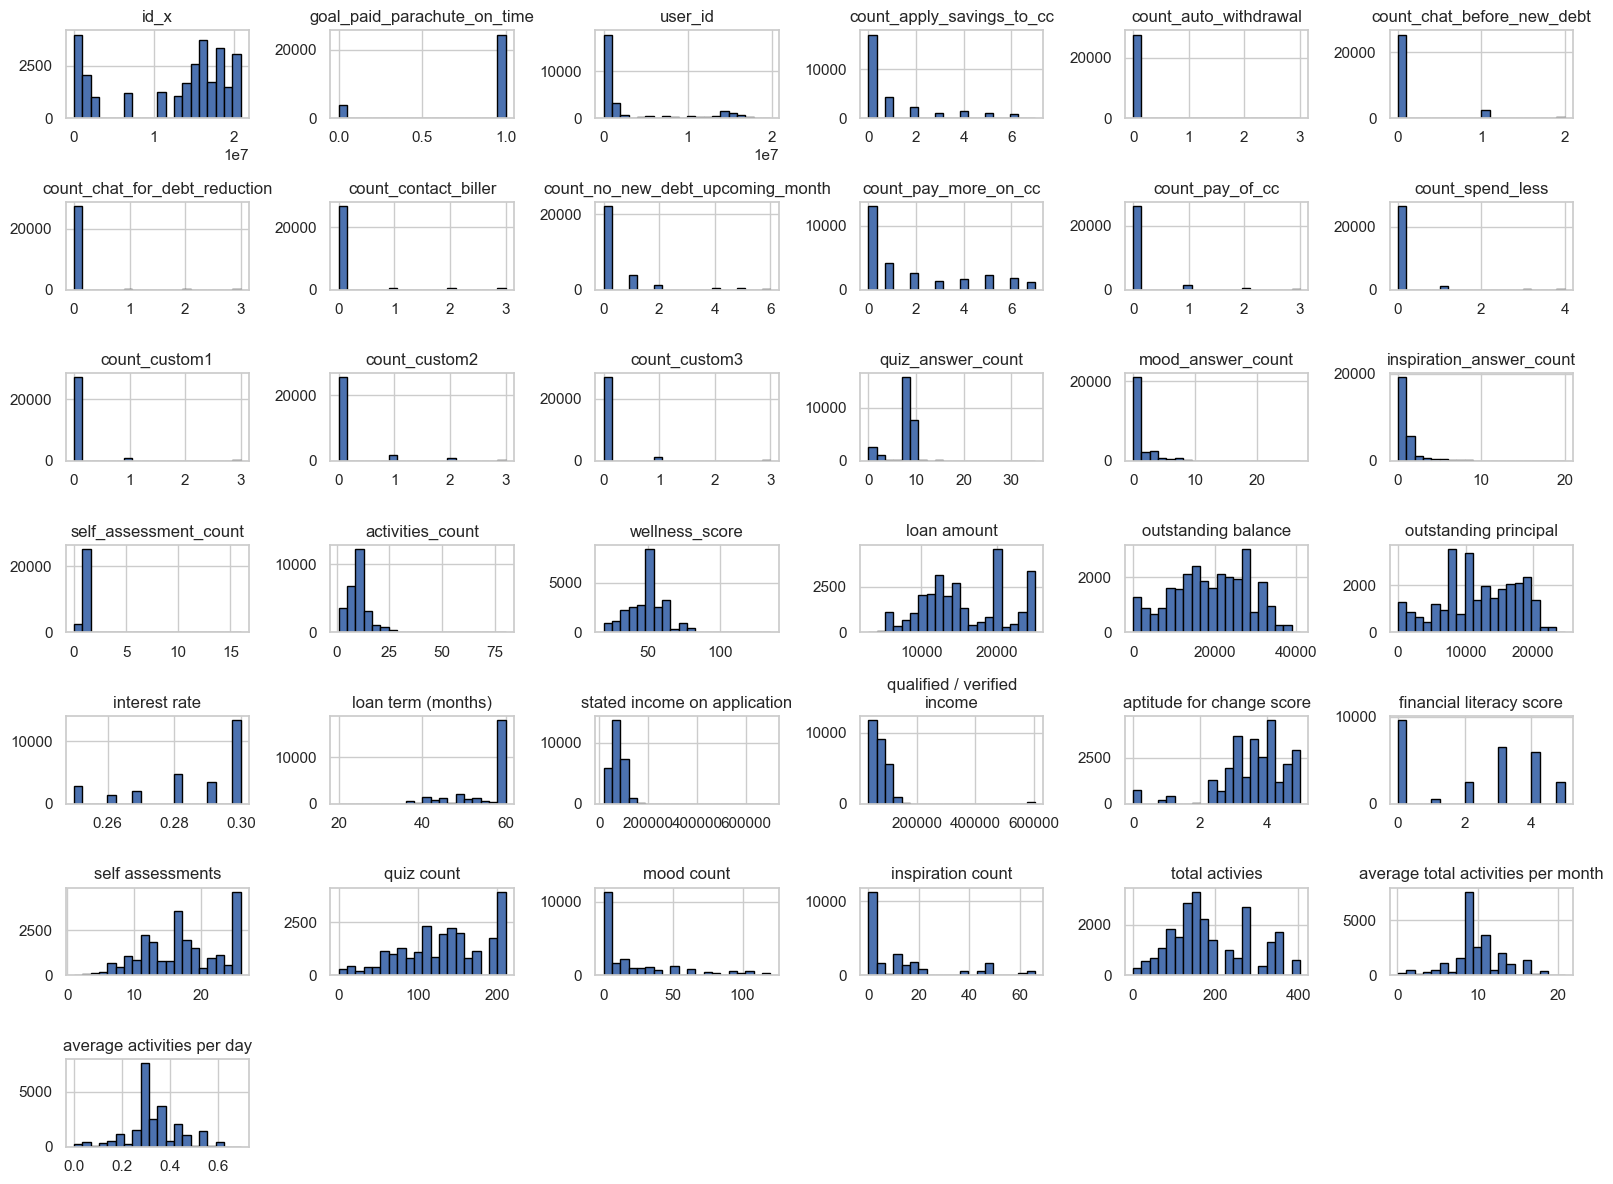


Plotting bar charts for categorical variables...


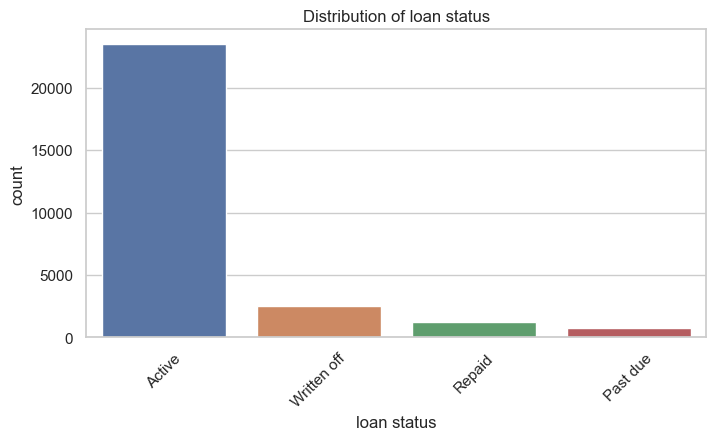

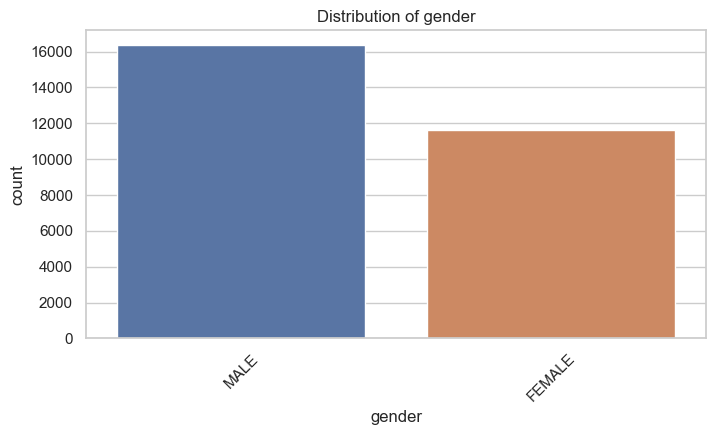

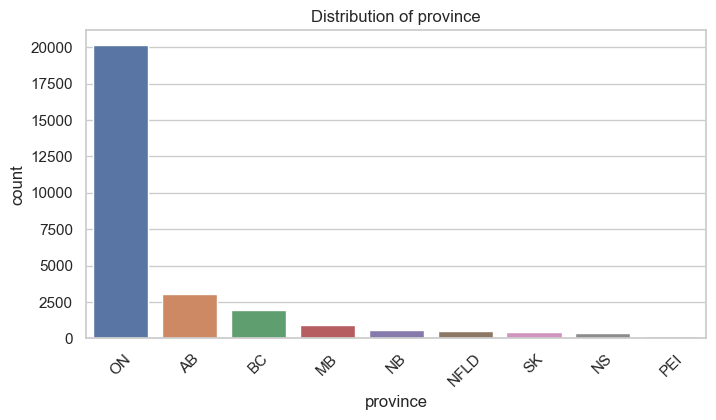

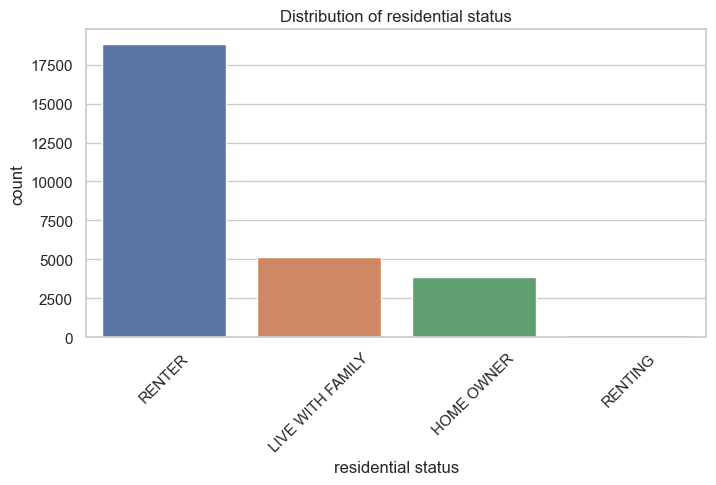


Correlation Matrix of Numeric Variables:


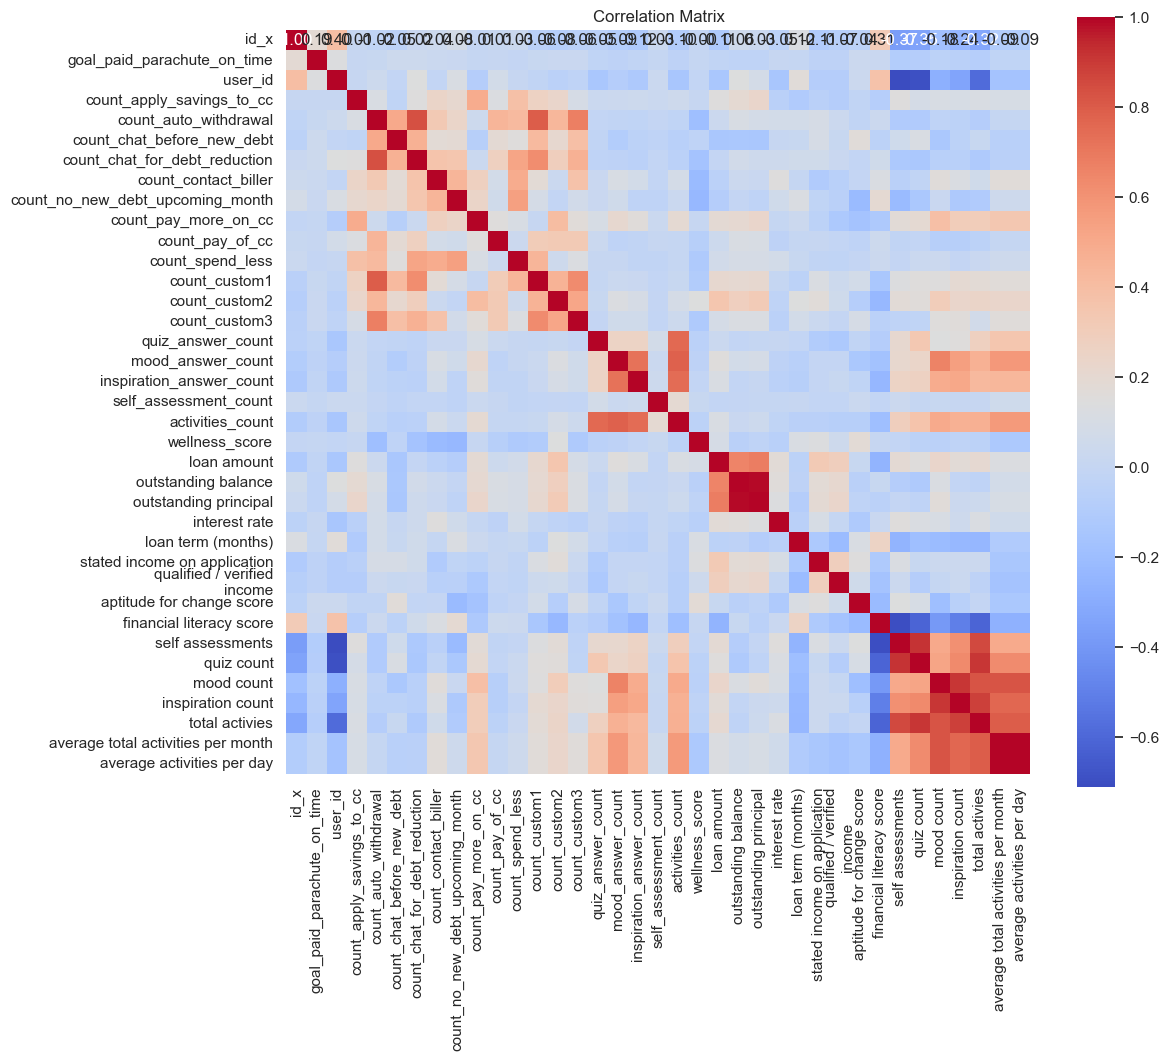

All subset columns are present in df_merged.

Plotting pairplot for selected variables...


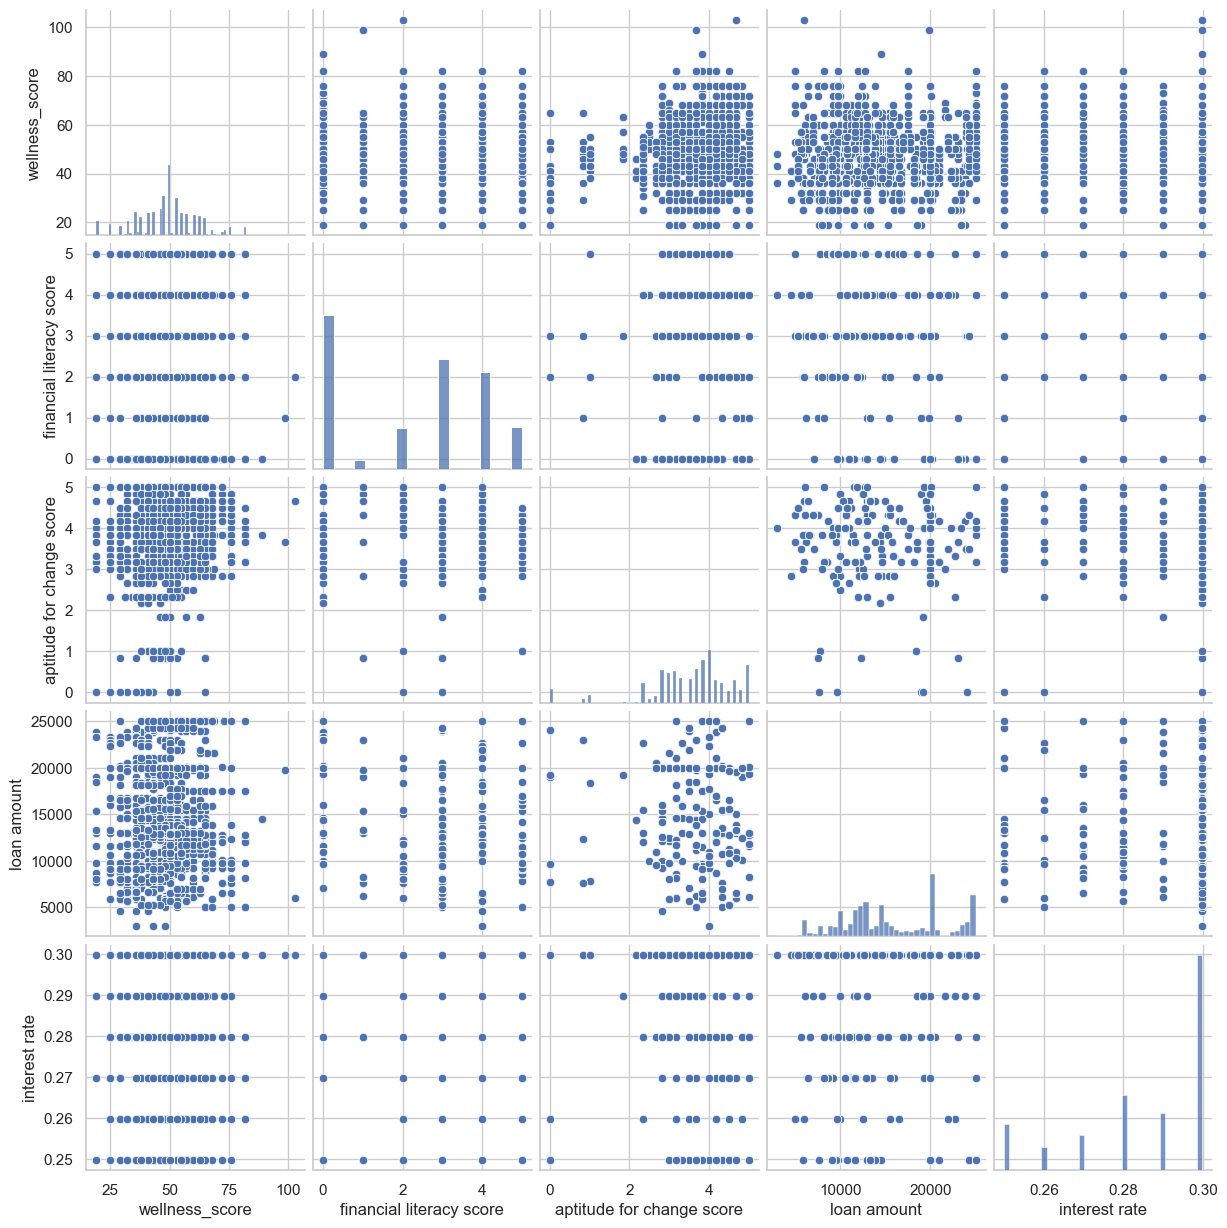


Scatter plots of numeric variables vs wellness_score:


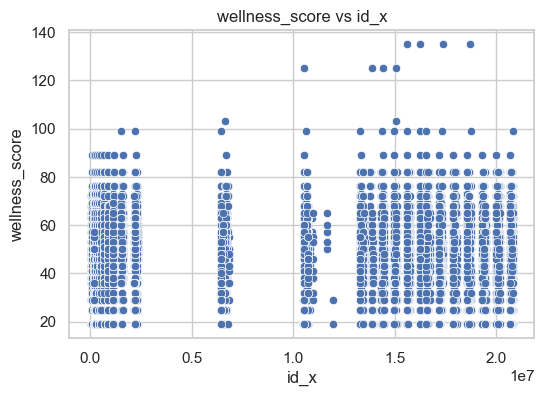

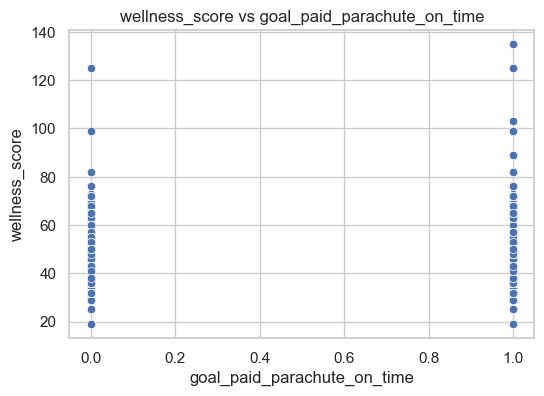

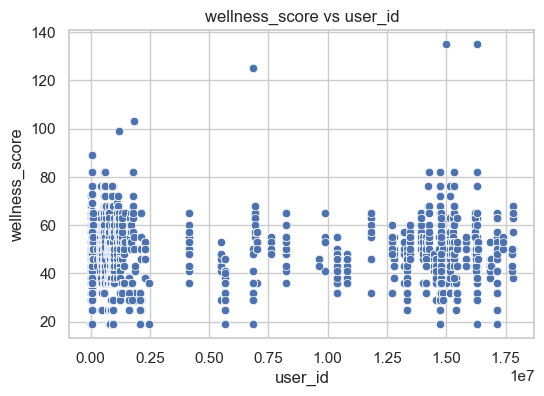

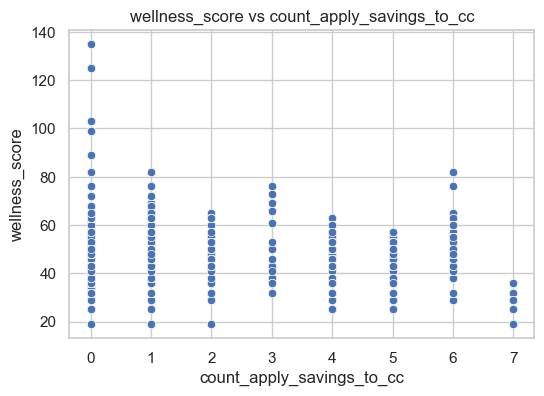

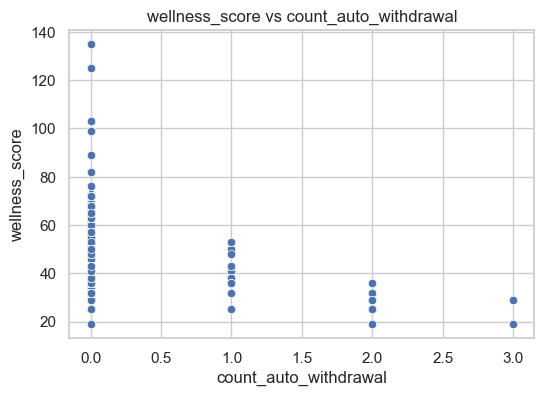

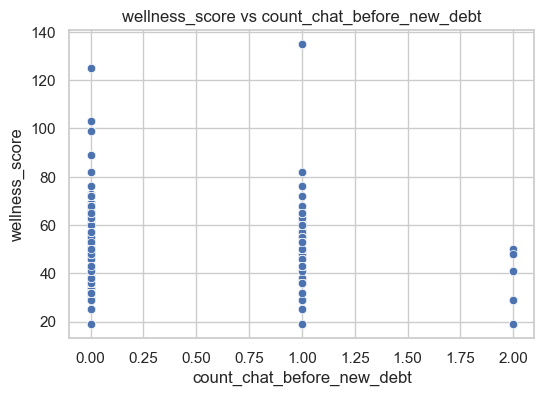

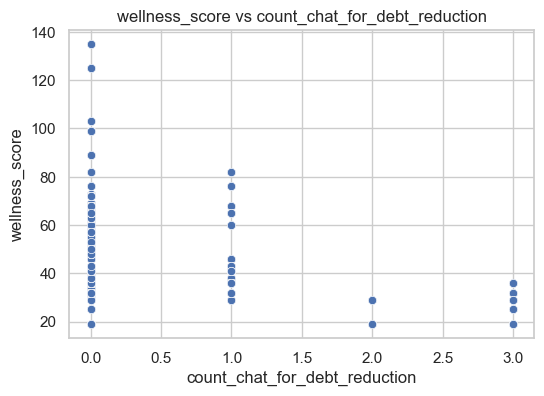

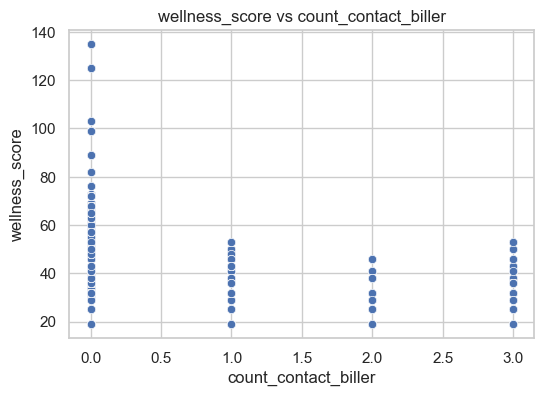

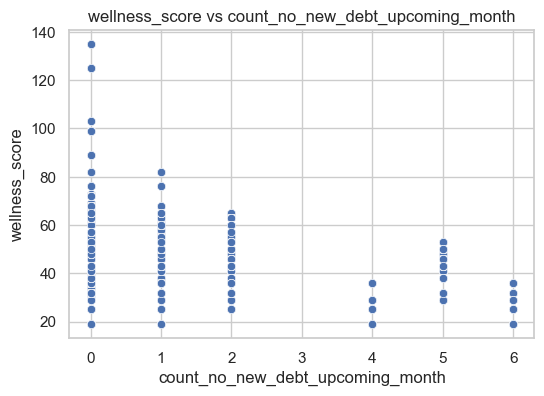

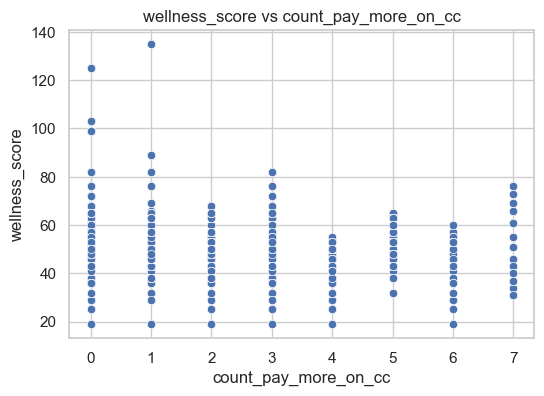

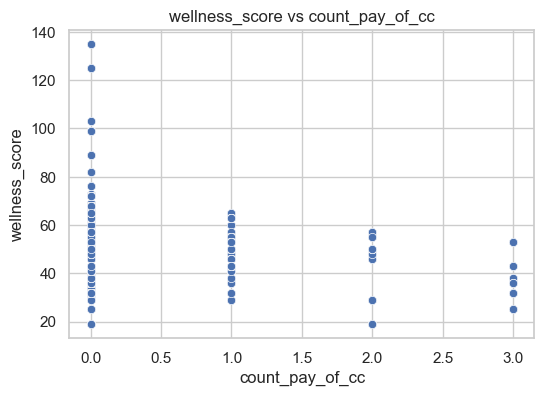

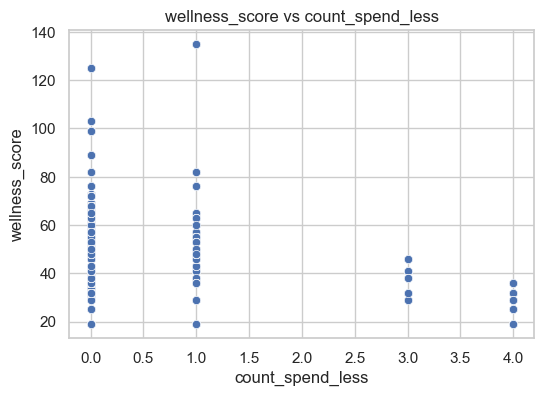

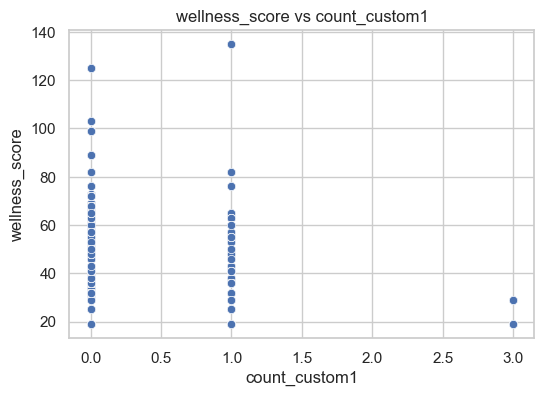

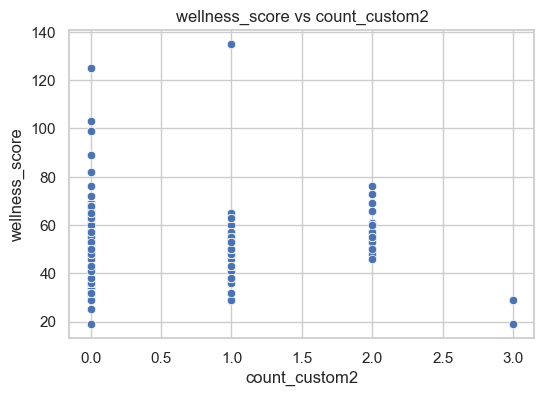

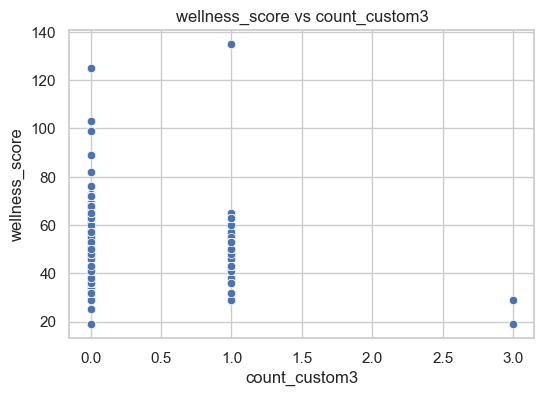

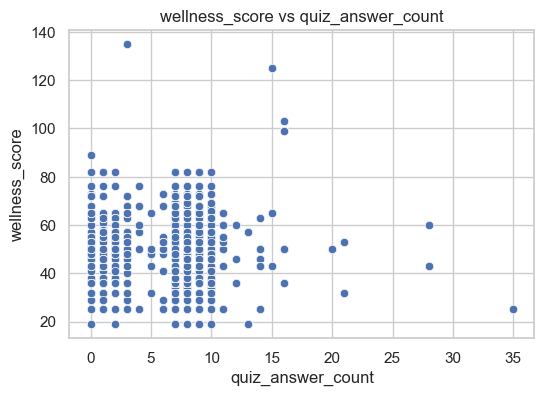

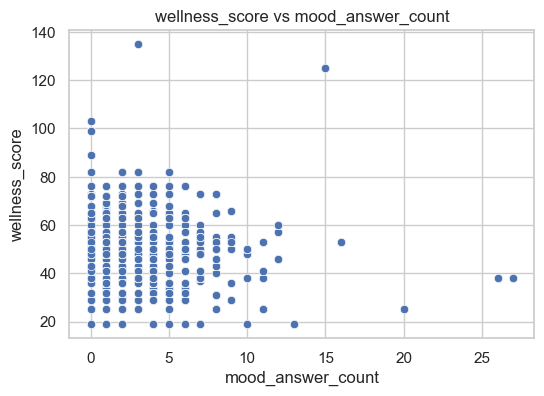

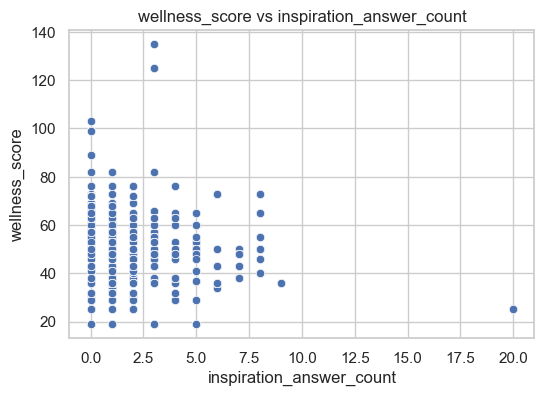

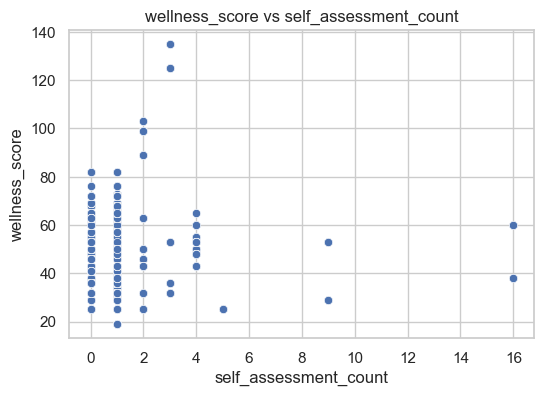

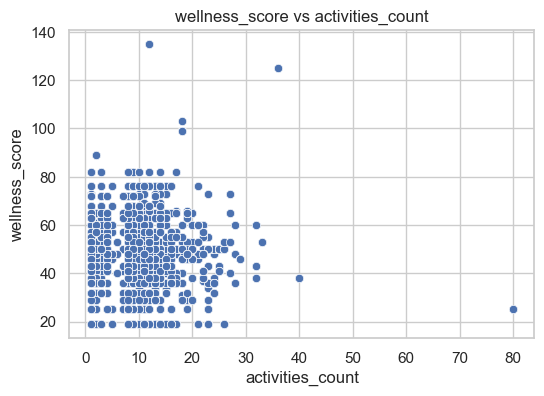

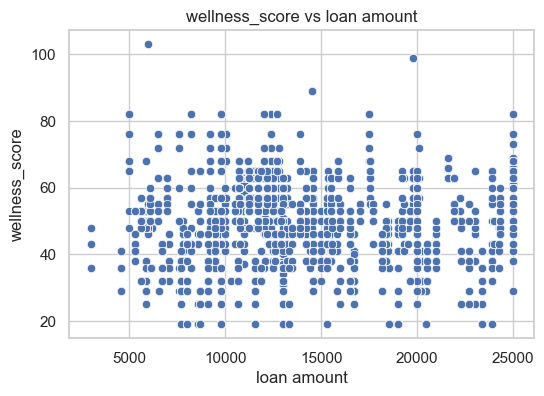

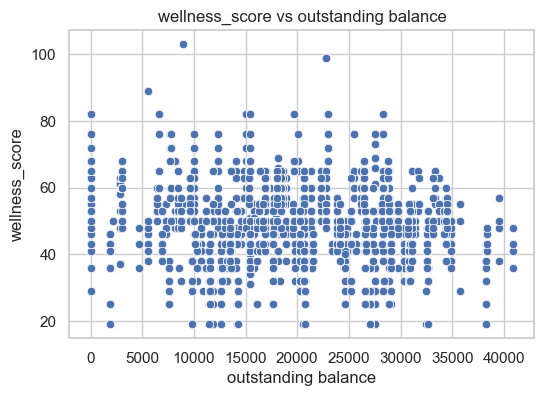

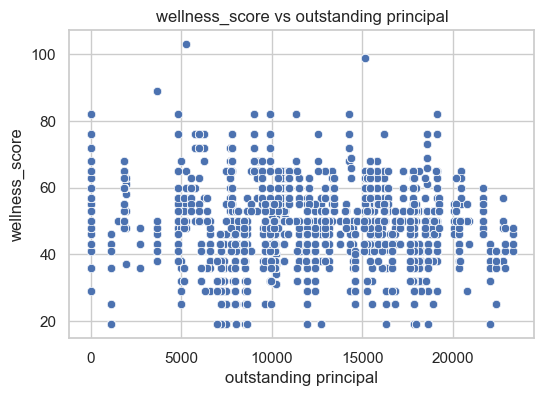

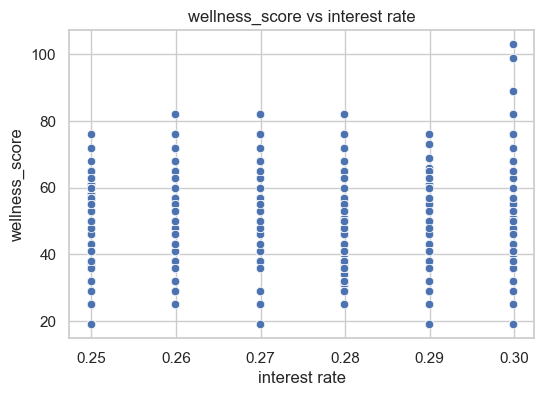

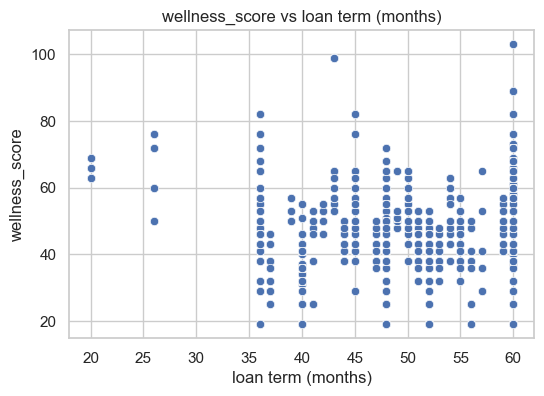

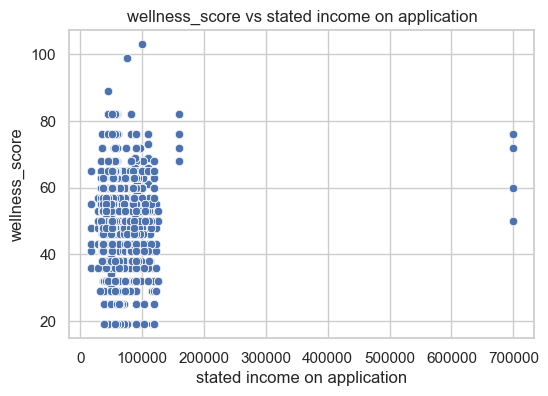

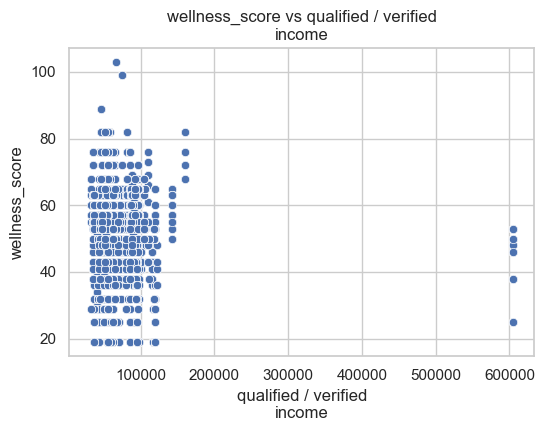

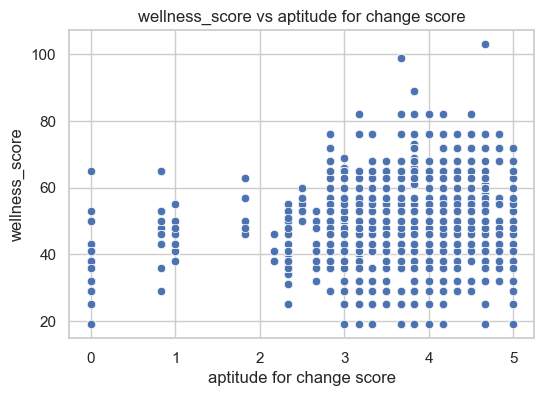

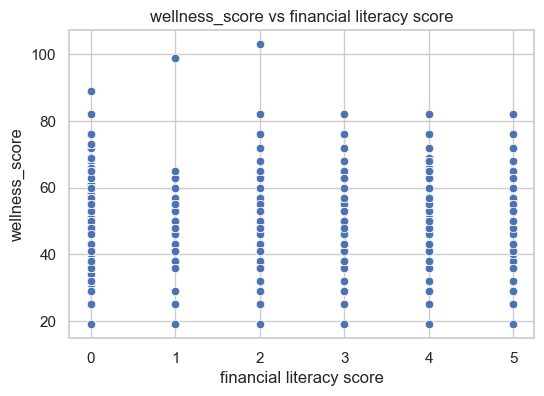

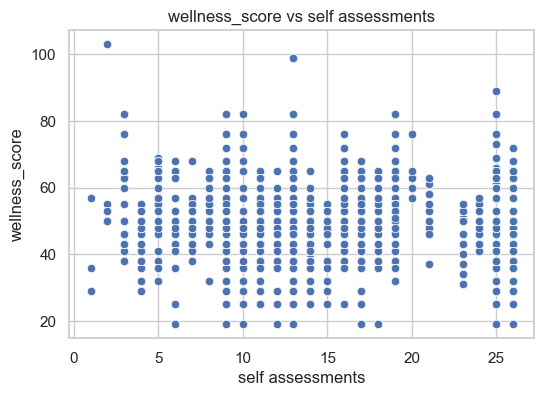

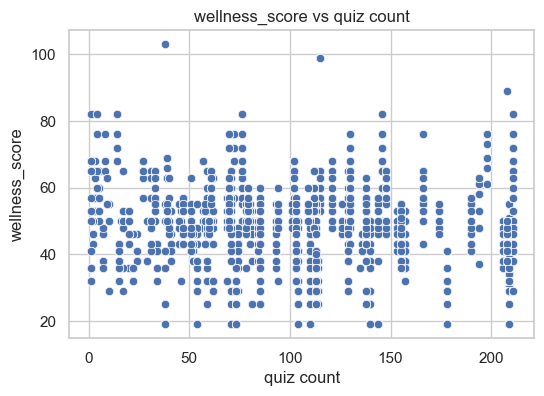

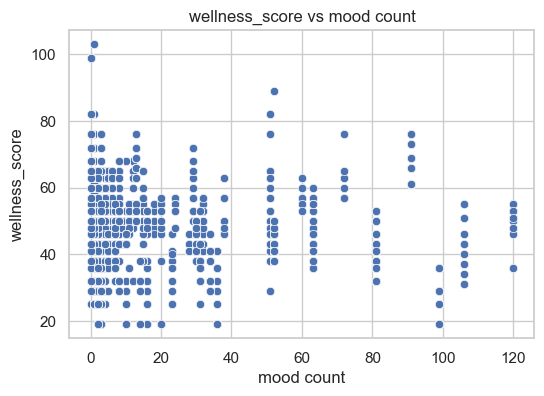

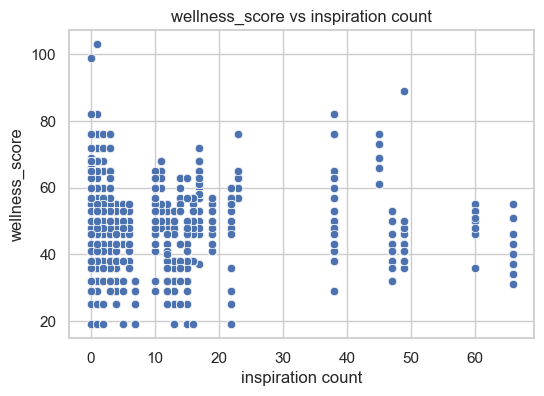

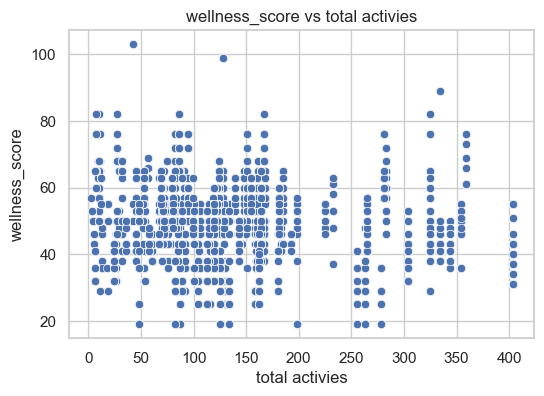

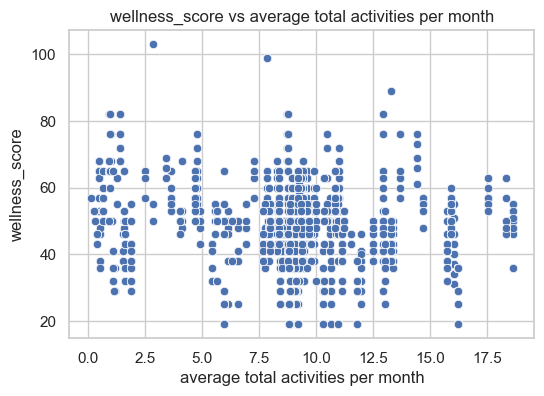

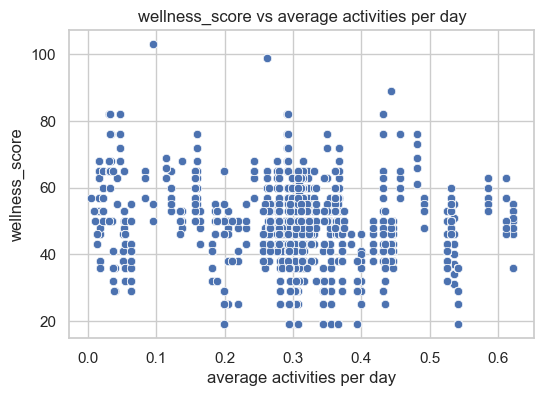


Boxplots of categorical variables vs wellness_score:


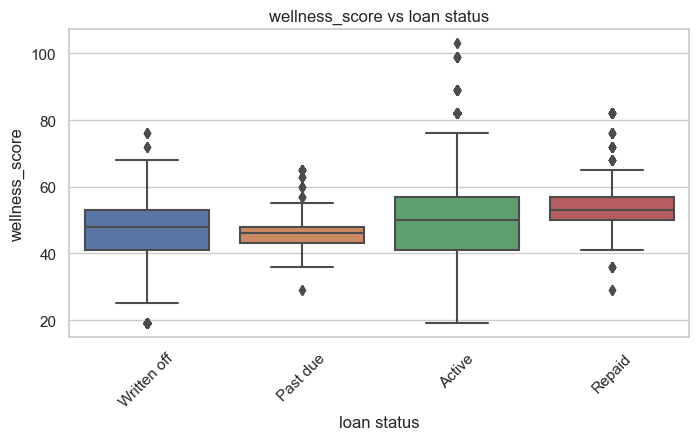

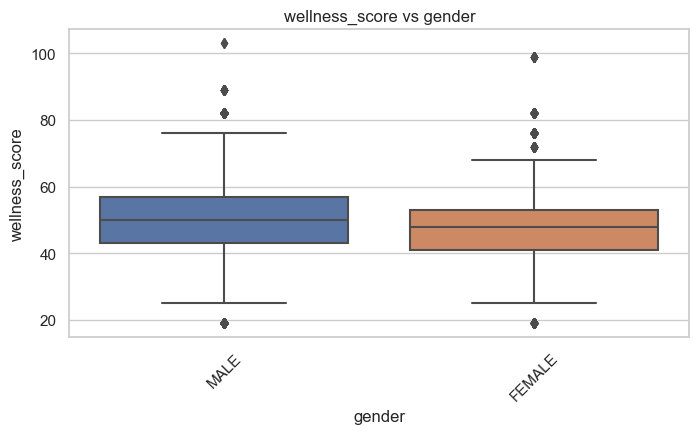

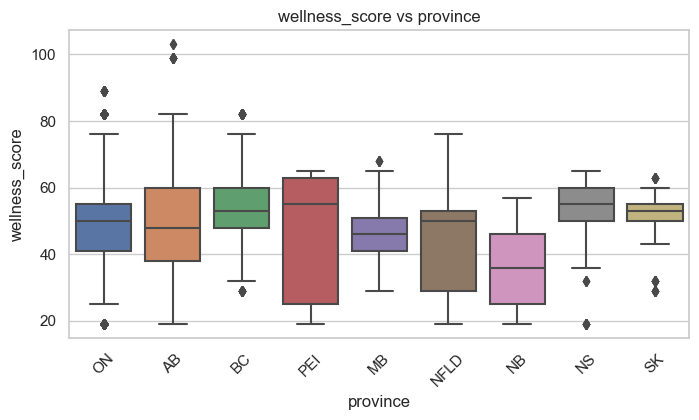

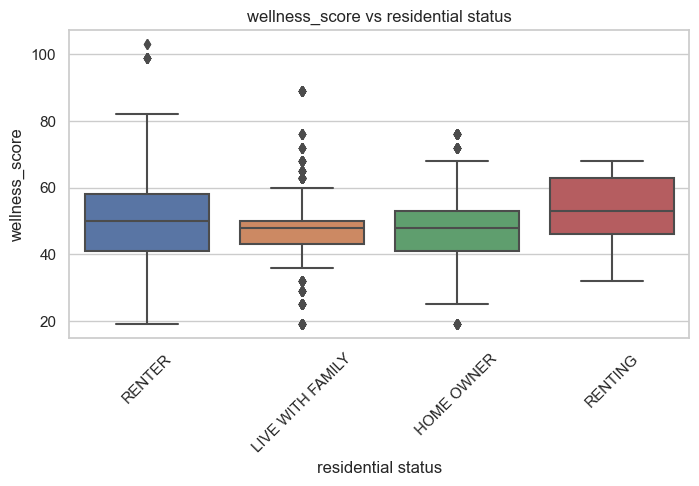


Skewness of numeric features:
self_assessment_count                 15.105092
count_auto_withdrawal                  9.364411
count_chat_for_debt_reduction          8.666671
qualified / verified\nincome           7.372560
count_custom1                          7.231085
stated income on application           6.690845
count_custom3                          6.660986
count_spend_less                       6.634656
count_contact_biller                   5.082107
count_pay_of_cc                        4.526149
count_custom2                          3.711856
inspiration_answer_count               3.664333
count_no_new_debt_upcoming_month       3.625215
mood_answer_count                      3.241440
count_chat_before_new_debt             3.162915
activities_count                       1.688177
count_apply_savings_to_cc              1.687246
user_id                                1.560785
mood count                             1.523400
inspiration count                      1.491962
count_pay

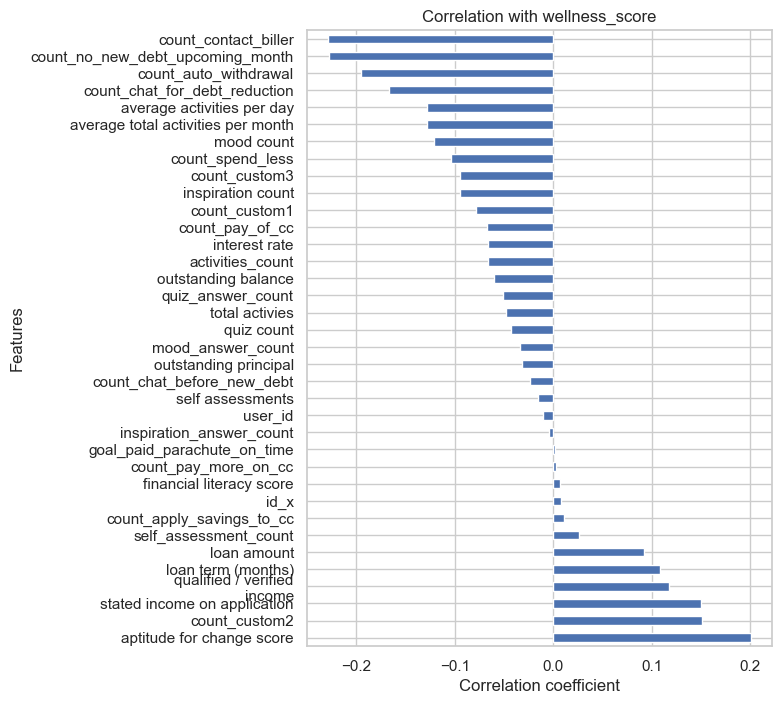


Cleaned data saved to 'cleaned_data.csv'.


ValueError: Input y contains NaN.

In [67]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization style
%matplotlib inline
sns.set(style='whitegrid', palette='deep')

# Load Data
df_crosssection = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Parachute - Cross Section')
df_crosssection['ID'] = df_crosssection['ID'].astype(str)

df_tu_panel = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='TU - Panel')

df_monthly_wellness = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Monthly Wellness and Engagement')
df_monthly_wellness['loanid'] = df_monthly_wellness['loanid'].astype(str)

df_goals_plans = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Goals_and_plans_ALLDATA_202410')
df_goals_plans['public_id'] = '1' + df_goals_plans['public_id'].astype(str)

df_additional_tu = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Addiitonal TU Data')

# Standardize column names in all DataFrames
dfs = [df_crosssection, df_tu_panel, df_monthly_wellness, df_goals_plans, df_additional_tu]
for df in dfs:
    df.columns = df.columns.str.strip().str.lower()

# Merge DataFrames
df_merged = df_goals_plans.merge(df_monthly_wellness, how='left', left_on='public_id', right_on='loanid')
df_merged = df_merged.merge(df_crosssection, how='left', left_on='public_id', right_on='id')

# Drop unnecessary columns
df_merged.drop(columns=['id', 'assessment_month', 'admin_notes', 'id-date'], errors='ignore', inplace=True)

# Drop duplicates
df_merged.drop_duplicates(inplace=True)

# Convert date columns to datetime
date_cols = ['assessment_completed_date', 'month_being_assessed', 'plan_date1', 'disbursement date', 'date of birth']

# Verify that all date columns exist
missing_date_cols = [col for col in date_cols if col not in df_merged.columns]
if missing_date_cols:
    print(f"The following date columns are missing in df_merged: {missing_date_cols}")
    # Remove missing columns from date_cols
    date_cols = [col for col in date_cols if col in df_merged.columns]

for col in date_cols:
    df_merged[col] = pd.to_datetime(df_merged[col], errors='coerce')

# Data Overview

# Preview the first few rows
print("First few rows of the merged dataset:")
display(df_merged.head())

# Get DataFrame info
print("\nDataFrame Information:")
df_merged.info()

# Summary statistics for numeric variables
print("\nSummary Statistics for Numeric Variables:")
display(df_merged.describe())

# Summary statistics for categorical variables
print("\nSummary Statistics for Categorical Variables:")
display(df_merged.describe(include=['object']))

# Handling Missing Values

# Calculate missing values
missing_values = df_merged.isnull().sum().sort_values(ascending=False)
missing_percent = (df_merged.isnull().sum() / len(df_merged) * 100).sort_values(ascending=False)

# Create a DataFrame for missing values
missing_data = pd.DataFrame({'Total Missing': missing_values, 'Percent Missing': missing_percent})
print("\nMissing Values in the Dataset:")
display(missing_data.head(20))

# Visualize missing data using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_merged.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Drop columns with more than 50% missing values
threshold = 50  # percent
columns_to_drop = missing_data[missing_data['Percent Missing'] > threshold].index
df_merged.drop(columns=columns_to_drop, inplace=True)

print(f"\nDropped columns due to high missing rate (> {threshold}%):")
print(list(columns_to_drop))

# Exploratory Data Analysis

# Identify numeric and categorical columns
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_merged.select_dtypes(include=['object']).columns.tolist()

# Univariate Analysis - Numeric Variables
print("\nPlotting histograms for numeric variables...")
df_merged[numeric_cols].hist(figsize=(16, 12), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

# Univariate Analysis - Categorical Variables
# Exclude columns with too many unique values
categorical_cols = [col for col in categorical_cols if df_merged[col].nunique() < 20 and col != 'public_id']

print("\nPlotting bar charts for categorical variables...")
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_merged, x=col, order=df_merged[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

# Bivariate Analysis - Correlation Matrix
print("\nCorrelation Matrix of Numeric Variables:")
corr_matrix = df_merged[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Bivariate Analysis - Pairplot
# Select a subset of numeric columns for pairplot
subset_cols = ['wellness_score', 'financial literacy score', 'aptitude for change score', 'loan amount', 'interest rate']

# Verify that all columns in subset_cols exist in df_merged
missing_cols = [col for col in subset_cols if col not in df_merged.columns]
if missing_cols:
    print(f"The following columns are missing in df_merged: {missing_cols}")
else:
    print("All subset columns are present in df_merged.")

# Proceed only if all columns are present
if not missing_cols:
    # Drop NaNs in these columns
    df_pairplot = df_merged[subset_cols].dropna()

    print("\nPlotting pairplot for selected variables...")
    sns.pairplot(df_pairplot)
    plt.show()
else:
    print("Pairplot cannot be created due to missing columns.")

# Bivariate Analysis - Relationship with Target Variable
target_variable = 'wellness_score'

if target_variable in df_merged.columns:
    print(f"\nScatter plots of numeric variables vs {target_variable}:")
    for col in numeric_cols:
        if col != target_variable:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(data=df_merged, x=col, y=target_variable)
            plt.title(f'{target_variable} vs {col}')
            plt.show()

    print(f"\nBoxplots of categorical variables vs {target_variable}:")
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_merged, x=col, y=target_variable)
        plt.xticks(rotation=45)
        plt.title(f'{target_variable} vs {col}')
        plt.show()
else:
    print(f"Target variable '{target_variable}' not found in df_merged.")

# Handling Skewness

from scipy.stats import skew

# Calculate skewness
skewness = df_merged[numeric_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print("\nSkewness of numeric features:")
print(skewness)

# Identify highly skewed features
skewed_features = skewness[abs(skewness) > 0.5].index

# Apply log transformation
for col in skewed_features:
    # Since log transformation cannot be applied to negative values, shift the data if necessary
    if (df_merged[col] <= 0).any():
        df_merged[col] = df_merged[col] - df_merged[col].min() + 1
    df_merged[col] = np.log1p(df_merged[col])

# Recalculate skewness after transformation
new_skewness = df_merged[skewed_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness after log transformation:")
print(new_skewness)

# Correlation with Target Variable

if target_variable in df_merged.columns:
    # Compute correlations with target variable
    target_corr = df_merged[numeric_cols].corr()[target_variable].sort_values(ascending=False)

    print(f"\nCorrelation with {target_variable}:")
    print(target_corr)

    # Plot correlations
    plt.figure(figsize=(6, 8))
    target_corr.drop(target_variable).plot(kind='barh')
    plt.title(f'Correlation with {target_variable}')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Features')
    plt.show()
else:
    print(f"Target variable '{target_variable}' not found in df_merged.")

# Feature Engineering (Optional)

# Create 'age' feature
if 'date of birth' in df_merged.columns:
    df_merged['age'] = (pd.Timestamp('today') - df_merged['date of birth']).dt.days // 365
    df_merged.drop(columns=['date of birth'], inplace=True)

# Save Cleaned Data for Modeling

# Save the cleaned and preprocessed data to a new CSV file
df_merged.to_csv('cleaned_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_data.csv'.")

# ------------------- Added Modeling Code Below -------------------

# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Proceed only if target variable exists
if target_variable in df_merged.columns:
    # 1. Data Preprocessing

    ## 1.1 Handling Remaining Missing Values

    # Separate features and target variable
    X = df_merged.drop(columns=[target_variable])
    y = df_merged[target_variable]

    # Identify numerical and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Handle missing values using imputation
    # We'll use mean imputation for numerical features and most frequent for categorical features

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # 2. Split Data into Training and Testing Sets

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 3. Create Modeling Pipeline

    # We'll start with a simple linear regression model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # 4. Model Training

    model.fit(X_train, y_train)

    # 5. Model Evaluation

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nLinear Regression Model Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # 6. Feature Importance Analysis

    # For linear regression, coefficients can be used to determine feature importance

    # Retrieve the names of the features after preprocessing
    onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    feature_names = numeric_cols + list(onehot_columns)

    # Retrieve the coefficients
    coefficients = model.named_steps['regressor'].coef_

    # Create a DataFrame for coefficients
    coeff_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort by absolute value of coefficient
    coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
    coeff_df.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

    print("\nTop Features based on Coefficients:")
    display(coeff_df.head(10))

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=coeff_df.head(10), x='Absolute Coefficient', y='Feature')
    plt.title('Top 10 Important Features - Linear Regression')
    plt.show()

    # 7. Try Other Models

    ## 7.1 Decision Tree Regressor

    # Create a pipeline for Decision Tree
    model_dt = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])

    # Train the model
    model_dt.fit(X_train, y_train)

    # Predict on test set
    y_pred_dt = model_dt.predict(X_test)

    # Evaluate the model
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    rmse_dt = np.sqrt(mse_dt)
    r2_dt = r2_score(y_test, y_pred_dt)

    print(f"\nDecision Tree Model Performance:")
    print(f"RMSE: {rmse_dt:.2f}")
    print(f"R^2 Score: {r2_dt:.2f}")

    # Feature Importance from Decision Tree
    importances_dt = model_dt.named_steps['regressor'].feature_importances_

    # Create DataFrame for feature importances
    feature_importance_dt = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_dt
    })

    # Sort by importance
    feature_importance_dt.sort_values(by='Importance', ascending=False, inplace=True)

    print("\nTop Features based on Decision Tree Importance:")
    display(feature_importance_dt.head(10))

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_dt.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Important Features - Decision Tree')
    plt.show()

    ## 7.2 Random Forest Regressor

    # Create a pipeline for Random Forest
    model_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Train the model
    model_rf.fit(X_train, y_train)

    # Predict on test set
    y_pred_rf = model_rf.predict(X_test)

    # Evaluate the model
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print(f"\nRandom Forest Model Performance:")
    print(f"RMSE: {rmse_rf:.2f}")
    print(f"R^2 Score: {r2_rf:.2f}")

    # Feature Importance from Random Forest
    importances_rf = model_rf.named_steps['regressor'].feature_importances_

    # Create DataFrame for feature importances
    feature_importance_rf = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_rf
    })

    # Sort by importance
    feature_importance_rf.sort_values(by='Importance', ascending=False, inplace=True)

    print("\nTop Features based on Random Forest Importance:")
    display(feature_importance_rf.head(10))

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_rf.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Important Features - Random Forest')
    plt.show()

    # 8. Interpretation

    # Analyze the top features from the Random Forest model to identify key drivers
    print("\nKey Drivers of Financial Wellbeing Identified:")
    display(feature_importance_rf.head(10))
else:
    print(f"Target variable '{target_variable}' not found in df_merged. Modeling cannot proceed.")